In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Table for data entries and abbreviations

#### Batting Data: G AB R H 2B 3B HR RBI BB IBB SO HBP SH SF XI ROE GDP SB CS AVG OBP SLG HAND

0: G: Games, total game played <br/>
1: AB: At bat, Total times at bat <br/>
2: R: Runs, total runs scored <br/>
3: H: Hits, total fair play hits <br/>
4: 2B: Double, reaching 2nd base from batting <br/>
5: 3B: Triple, reaching 3rd base from batting <br/>
6: HR: Home run, scoring straight from batting (includes in field home runs) <br/>
7: RBI: Runs batted in, total runs from this player's at bat <br/>
8: BB: Walks, total times walked (includes intentional walks) <br/>
9: IBB: Intentional Walk, intentionally walking batter to first base <br/>
10: SO: Strike out, total times struck out at base <br/>
11: HBP: Hit by pitch, total times <br/>
12: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
13: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
14: XI: Reached First on Interference, (almost all players have 0 for this statistic) <br/>
15: ROE: Reached on error, total times on base due to an error <br/>
16: GDP: Grounded into double play <br/>
17: SB: Stolen base, total bases stolen <br/>
18: CS: Caught stealing, Total times getting out when stealing.<br/>
19: AVG: Batting average, (total hits / total at bats) <br/>
20: OBP: On base percentage, (total times on base / total at bats) <br/>
21: SLG: Slugging percentage, bases per at bat ((1B + 2*2B + 3*3B + 4*HR) / AB) <br/>
22: HAND: Handedness, batting hand (1 = right, -1 = left) <br/>



#### Pitching Data: G GS CG SHO GF SV IP H BFP HR R ER BB IB SO SH SF WP HBP BK 2B 3B GDP ROE W L ERA RS PW HAND

0: G: Games played, total games played <br/>
1: GS: Games Started, threw the first pitch <br/>
2: CG: Complete game, pitched for the entire game <br/>
3: SHO: Shutout, pitches entire game without opposition scoring <br/>
4: GF: Games Finished, threw the last pitch (not counted if there was only 1 pitcher for the game) <br/>
5: SV: save, relief pitcher resulting in a win under certain conditions, https://www.mlb.com/glossary/standard-stats/save <br/>
6: IP: Innings pitched, total innings pitched (can be partial) <br/>
7: H: Hits, total hits allowed <br/>
8: BFP: Total batters face, total batters at plate when pitching <br/>
9: HR: Home runs allowed <br/>
10: R: Runs allowed, total runs allowed <br/>
11: ER: Earned Run, total runs scored by the opposition due to the pitcher <br/>
12: BB: Walk, total walks <br/>
13: IB: Intentional walk <br/>
14: SO: Strikeout, total batters struck out <br/>
15: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
16: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
17: WP: Wild pitches, pitch out of range for the catcher causing a runner to advance <br/>
18: HBP: Hit by pitch, times batter is hit by a pitch <br/>
19: BK: Balk, number of illegal actions <br/>
20: 2B: Doubles allowed <br/>
21: 3B: Triples allowed <br/>
22: GDP: Grounded double plays <br/>
23: ROE: Reached on error, number of batters on base due to an error <br/>
24: W: Win, pitched while their team took the team and won the game <br/>
25: L: Loss, pitched while their team lost the lead and lost the game <br/>
26: ERA: Earned run average, (allowed runs * 9 / innings pitched ) <br/>
27: RS: Run support, average opposition score (per game, not per inning) <br/>
28: PW: Total player rating, linear weighting of multiple statistics, https://en.wikipedia.org/wiki/Total_player_rating <br/>
29: HAND: Handedness, Pitching hand (1 = right, -1 = left) <br/>

In [2]:
def getDataFromFile(fileName, pitchingDataList, battingDataList):
    fileData=np.loadtxt(fileName, delimiter=',') 
    [N,dim]=np.shape(fileData) #set up matrix from file
    
    fileX = np.zeros((N, dim))
    dataY = np.zeros((N))
    
    fileX = fileData[:, 0:dim - 1] #remove output from the x array
    dataY[:] = fileData[:, dim - 1]
    
    dataX = np.zeros((N, 2*len(pitchingDataList) + 18*len(battingDataList)))
    dataXIndex = 0
    for i in pitchingDataList: #add data for home pitcher
        dataX[:,dataXIndex] = fileX[:,i]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for home batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(30 + 23*i + j)]
            dataXIndex = dataXIndex + 1
    for i in pitchingDataList: #add data for away pitcher
        dataX[:,dataXIndex] = fileX[:,(30 + 23*9 + i)]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for away batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(2*30 + 23*(9+i) + j)]
            dataXIndex = dataXIndex + 1
    
    return dataX, dataY


def getMeanAndStd(data): #get the mean and standard deviation of data columns
    means = [] #mean for each column
    stds = [] #standard deviation for each column
    for i in range(np.shape(data)[1]):
        mean = sum(data[:,i]) / len(data) 
        means.append(mean)
        stds.append( np.sqrt( sum((mean - data[:,i])**2)/len(data)) )
    return means, stds

def applyMeanAndStd(data, means, stds):
    newData = data
    for i in range(np.shape(newData)[1]):
        newData[:,i] = (data[:,i] - means[i])/stds[i] #normalize so that mean = 0, std = 1
    return newData


def structureGameData(gameData, batSize, pitSize): #take a single game and break into 2 pitching lists and 18 batting lists
    index = 0
    game = []
    game.append(gameData[index : index + pitSize]) #add home pitcher
    index = index + pitSize
    for i in range(9): #add home batters
        game.append(gameData[index : index + batSize])
        index = index + batSize
    game.append(gameData[index : index + pitSize]) #add away pitcher
    index = index + pitSize
    for i in range(9): #add away batters
        game.append(gameData[index : index + batSize])
        index = index + batSize
    
    return game

# WARNING: this function is specific to the current data lists, if the list changes the function should as well
def reformatGameData(games, batData, pitData):
    newGames = np.zeros((len(games), np.shape(games)[1] - 1*20)) #drop 20 per entry since we remove at bats and inning pitched
    
    pitSize = len(pitData)
    batSize = len(batData)

    for gameNum in range(len(games)):
        game = games[gameNum]
        gameStruct = structureGameData(game, batSize, pitSize)
        
        for batter in range(1 + 0, 1 + 9): #for each home batter
            for i in range(1, 10): #all data points except: at bats, bat avr%, hand will be divided by the # of at bats
                if(gameStruct[batter][0] != 0):
                    gameStruct[batter][i] = gameStruct[batter][i] / gameStruct[batter][0]
        for batter in range(11 + 0, 11 + 9): #for each away batter
            for i in range(1, 10): #all data points except: at bats, bat avr%, hand will be divided by the # of at bats
                if(gameStruct[batter][0] != 0):
                    gameStruct[batter][i] = gameStruct[batter][i] / gameStruct[batter][0]
                
        for i in range(1,7): #for home and away pitcher
            if(gameStruct[0][0] != 0):
                gameStruct[0][i] = gameStruct[0][i] / gameStruct[0][0]
            if(gameStruct[10][0] != 0):
                gameStruct[10][i] = gameStruct[10][i] / gameStruct[10][0]
        
        for i in range(len(gameStruct)): #throw away the first element of each list (either at bats, or innings pitched)
            gameStruct[i] = gameStruct[i][1:]
        flatGameStruct = []
        for elem in gameStruct: #flatten out list of lists
            for elem2 in elem: #list elements of list
                flatGameStruct.append(elem2)
        
        newGames[gameNum] = np.asarray(flatGameStruct) #flatten out since gameStruct is a list of lists
    return newGames

In [3]:
trainFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\train.txt"
valFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\val.txt"
testFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\test.txt"

batDataList = [1, 3, 4, 5, 6, 7, 9, 10, 17, 18, 19, 22] 
# at bats, hits, doubles, triples, home runs, rbi, intentional walks, strike outs, stolen bases, 
#...times caught stealing, batting avr %, handedness

#batDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] #all parameters

pitDataList = [6, 7, 20, 21, 9, 10, 14, 29] 
#innings pitched, hits allowed, doubles allowed, triples allowed, home runs allowed, runs allowed, strikeouts, handedness
#pitDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29] #all parameters

trainX, trainY = getDataFromFile(trainFileName, pitDataList, batDataList) # ~ 32000 examples
valX, valY = getDataFromFile(valFileName, pitDataList, batDataList) #8000 examples
testX, testY = getDataFromFile(testFileName, pitDataList, batDataList)


#reformat data
trainX = reformatGameData(trainX, batDataList, pitDataList)
valX = reformatGameData(valX, batDataList, pitDataList)
testX = reformatGameData(testX, batDataList, pitDataList)

#normalize the data
dataMeans, dataStds = getMeanAndStd(trainX)
trainX = applyMeanAndStd(trainX, dataMeans, dataStds)
valX = applyMeanAndStd(valX, dataMeans, dataStds)
testX = applyMeanAndStd(testX, dataMeans, dataStds)

In [4]:
def runModel(trainX, trainY, testX, testY, model, epochCount, printMode=0): #run and graph model results
    #compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    historyData = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochCount, verbose = printMode)
    eIn = historyData.history["accuracy"]
    eOut = historyData.history["val_accuracy"]
    
    for i in range(len(eIn)):
        eIn[i] = 1-eIn[i]
    for i in range(len(eOut)):
        eOut[i] = 1-eOut[i]

    print('Train error:', eIn[-1])
    print('Test error: ', eOut[-1])
    
    #return error data to be plot later
    return eIn, eOut

Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.4606972932815552
Test error:  0.4518749713897705
Train error: 0.3562893271446228
Test error:  0.4508749842643738
Train error: 0.33874982595443726
Test error:  0.44975000619888306
Train error: 0.2875441312789917
Test error:  0.45512497425079346
Train error: 0.026017487049102783
Test error:  0.48100000619888306


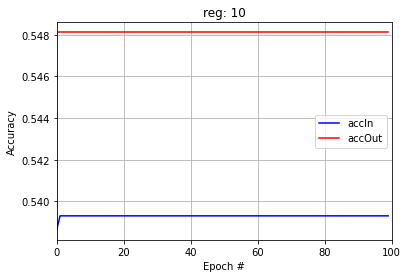

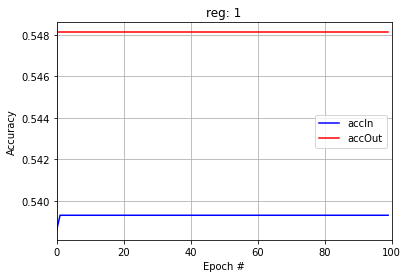

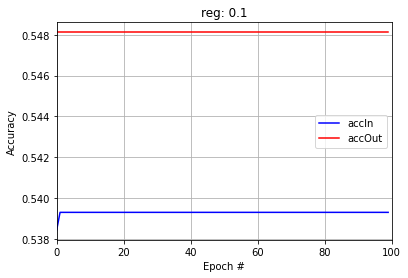

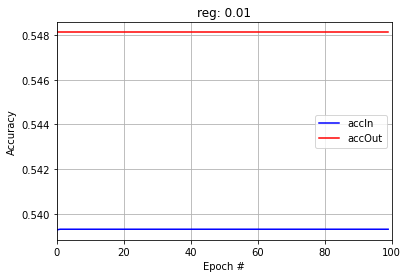

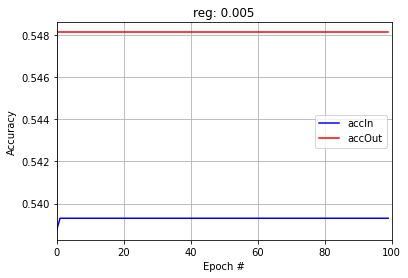

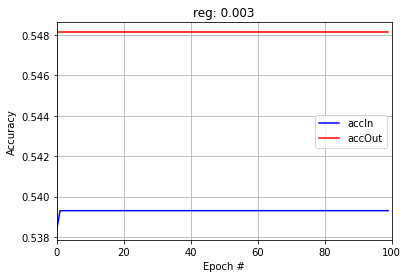

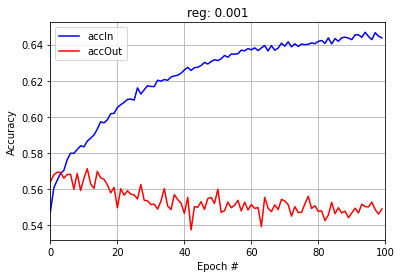

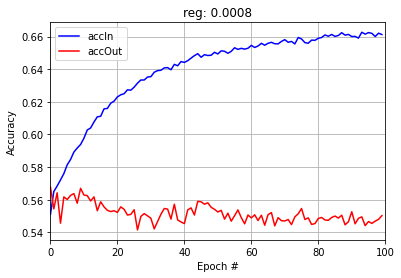

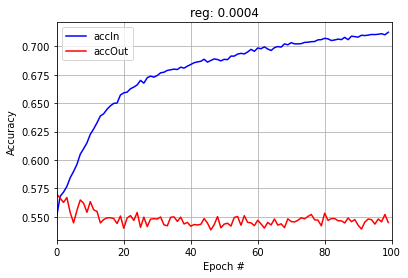

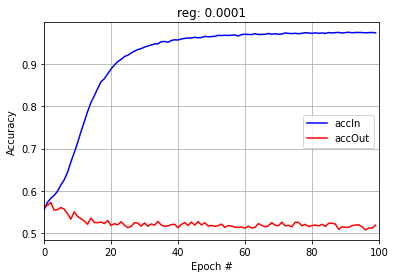

In [18]:
#regParam = keras.regularizers.l2(.001) #create regularization parameter
regValues = [10, 1, .1, .01, .005, .003, .001, .0008, .0004, .0001]

for regV in regValues:
    regParam = keras.regularizers.l2(regV) #create regularization parameter
    modelInter = tf.keras.Sequential([
            keras.layers.Dense(units=np.shape(trainX)[1], activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=125, activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=75, activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=50, activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=25, activation='relu', kernel_regularizer=regParam),
            keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=regParam)
        ])

    epochs = 100
    eIn, eOut = runModel(trainX, trainY, testX, testY, modelInter, epochs, printMode=0)

    fig, ax=plt.subplots()
    ax.plot(1-np.asarray(eIn),'-b')
    ax.plot(1-np.asarray(eOut),'-r')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel("Accuracy")
    ax.set_title("reg: " + str(regV))
    ax.grid()
    ax.legend(['accIn', 'accOut'])
    ax.axes.set_xlim([0,epochs])
    ax.plot()

Epoch 1/250
1018/1018 [==============================] - 4s 3ms/step - loss: 1.0392 - accuracy: 0.5490 - val_loss: 0.7098 - val_accuracy: 0.5669
Epoch 2/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.7001 - accuracy: 0.5677 - val_loss: 0.6911 - val_accuracy: 0.5696
Epoch 3/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6915 - accuracy: 0.5647 - val_loss: 0.6908 - val_accuracy: 0.5655
Epoch 4/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6902 - accuracy: 0.5677 - val_loss: 0.6900 - val_accuracy: 0.5654
Epoch 5/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6849 - accuracy: 0.5810 - val_loss: 0.6881 - val_accuracy: 0.5727
Epoch 6/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6855 - accuracy: 0.5777 - val_loss: 0.6898 - val_accuracy: 0.5623
Epoch 7/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6863 - accuracy: 0.5774 - val_loss: 0.6898 - val_ac

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6709 - accuracy: 0.6256 - val_loss: 0.7039 - val_accuracy: 0.5592
Epoch 58/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6730 - accuracy: 0.6214 - val_loss: 0.7035 - val_accuracy: 0.5524
Epoch 59/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6720 - accuracy: 0.6216 - val_loss: 0.7042 - val_accuracy: 0.5602
Epoch 60/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6700 - accuracy: 0.6249 - val_loss: 0.7046 - val_accuracy: 0.5605
Epoch 61/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6733 - accuracy: 0.6225 - val_loss: 0.7089 - val_accuracy: 0.5462
Epoch 62/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6731 - accuracy: 0.6210 - val_loss: 0.7040 - val_accuracy: 0.5530
Epoch 63/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6747 - accuracy: 0.6195 - val_loss: 0.7083 - val_accuracy

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6703 - accuracy: 0.6304 - val_loss: 0.7171 - val_accuracy: 0.5431
Epoch 114/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6692 - accuracy: 0.6339 - val_loss: 0.7189 - val_accuracy: 0.5481
Epoch 115/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6681 - accuracy: 0.6373 - val_loss: 0.7116 - val_accuracy: 0.5537
Epoch 116/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6709 - accuracy: 0.6305 - val_loss: 0.7134 - val_accuracy: 0.5516
Epoch 117/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6694 - accuracy: 0.6301 - val_loss: 0.7140 - val_accuracy: 0.5493
Epoch 118/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6667 - accuracy: 0.6370 - val_loss: 0.7143 - val_accuracy: 0.5441
Epoch 119/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6689 - accuracy: 0.6354 - val_loss: 0.7157 - val_ac

Epoch 169/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6682 - accuracy: 0.6370 - val_loss: 0.7145 - val_accuracy: 0.5533
Epoch 170/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6697 - accuracy: 0.6343 - val_loss: 0.7170 - val_accuracy: 0.5524
Epoch 171/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6704 - accuracy: 0.6331 - val_loss: 0.7167 - val_accuracy: 0.5504
Epoch 172/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6702 - accuracy: 0.6325 - val_loss: 0.7186 - val_accuracy: 0.5468
Epoch 173/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6714 - accuracy: 0.6312 - val_loss: 0.7141 - val_accuracy: 0.5583
Epoch 174/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6698 - accuracy: 0.6344 - val_loss: 0.7162 - val_accuracy: 0.5525
Epoch 175/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6682 - accuracy: 0.6341 - val_loss: 0

Epoch 225/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6713 - accuracy: 0.6300 - val_loss: 0.7129 - val_accuracy: 0.5552
Epoch 226/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6699 - accuracy: 0.6332 - val_loss: 0.7212 - val_accuracy: 0.5444
Epoch 227/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6661 - accuracy: 0.6373 - val_loss: 0.7120 - val_accuracy: 0.5512
Epoch 228/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6698 - accuracy: 0.6336 - val_loss: 0.7129 - val_accuracy: 0.5535
Epoch 229/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6673 - accuracy: 0.6398 - val_loss: 0.7137 - val_accuracy: 0.5571
Epoch 230/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6665 - accuracy: 0.6418 - val_loss: 0.7144 - val_accuracy: 0.5499
Epoch 231/250
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6686 - accuracy: 0.6360 - val_loss: 0

[]

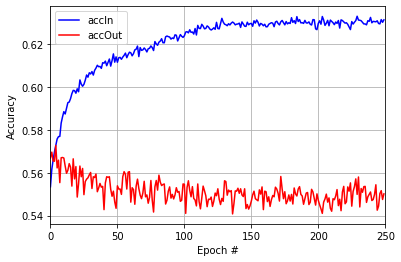

In [6]:
regParam = keras.regularizers.l2(.002) #create regularization parameter
modelInter = tf.keras.Sequential([
        keras.layers.Dense(units=np.shape(trainX)[1], activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=125, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=75, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=50, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=25, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=regParam)
    ])

epochs = 250
eIn, eOut = runModel(trainX, trainY, testX, testY, modelInter, epochs, printMode=1)

fig, ax=plt.subplots()
ax.plot(1-np.asarray(eIn),'-b')
ax.plot(1-np.asarray(eOut),'-r')
ax.set_xlabel('Epoch #')
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(['accIn', 'accOut'])
ax.axes.set_xlim([0,epochs])
ax.plot()